In [2]:
import dask.dataframe as dd
from rdkit.DataStructs.cDataStructs import BulkTanimotoSimilarity
from rdkit import Chem
from rdkit.Chem import MolFromSmiles
from rdkit.Chem import AllChem
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
import numpy as np
import math

In [2]:
from rdkit import Chem
from rdkit.Chem import MolStandardize, rdMolDescriptors, MolFromSmiles

def harmonize_smiles_rdkit(smiles, tautomer_limit = 900):
    try:
        # take the largest covalently bound molecule
        smiles_largest = MolStandardize.fragment.LargestFragmentChooser(smiles).prefer_organic
        mol = Chem.MolFromSmiles(smiles_largest)

        monomass = rdMolDescriptors.CalcExactMolWt(mol)
        # standardize tautomer
        if monomass < tautomer_limit:
            smiles_largest = MolStandardize.canonicalize_tautomer_smiles(smiles_largest)
            mol = Chem.MolFromSmiles(smiles_largest)

        # remove unnecessary charges
        uc = MolStandardize.charge.Uncharger()
        uncharged_mol = uc.uncharge(mol)
        
        # standardize the molecule
        lfc = MolStandardize.fragment.LargestFragmentChooser()
        standard_mol = lfc.choose(uncharged_mol)

        # remove stereochemistry
        Chem.RemoveStereochemistry(standard_mol)

        # get the standardized SMILES
        standard_smiles = Chem.MolToSmiles(standard_mol)
        return standard_smiles

    except Exception as e:
        print(f"An error occurred with input {smiles}: {e}")
        return ""




In [3]:
summary = dd.read_csv('/home/user/SourceCode/GNPS_ML_Processing_Workflow/work/06/3a7d3153673398fef6bb3957a45738/ALL_GNPS_cleaned.csv', dtype={'Smiles':str,'msDetector':str,'msDissociationMethod':str,'msManufacturer':str,'msMassAnalyzer':str,'msModel':str})
print(type(summary))

<class 'dask.dataframe.core.DataFrame'>


In [4]:
summary

,scan,spectrum_id,collision_energy,retention_time,Adduct,Compound_Source,Precursor_MZ,ExactMass,Charge,Ion_Mode,Smiles,INCHI,InChIKey_smiles,InChIKey_inchi,msModel,msManufacturer,msDetector,msMassAnalyzer,msIonisation,msDissociationMethod,GNPS_library_membership,GNPS_Inst
npartitions=2,,,,,,,,,,,,,,,,,,,,,,
,int64,object,float64,float64,object,object,float64,float64,int64,object,object,object,object,object,object,object,object,object,object,object,object,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [5]:
# summary = summary.loc['2000':'2005']    # for testing purposes
# print(type(summary))
# summary

In [6]:
def smiles_parser(smiles_string:str) -> list:
    """
    Takes a smiles string and returns a list of floats
    """
    if type(smiles_string) != str:
        print(math.isnan(smiles_string))

    if smiles_string == "nan" or smiles_string == None:
        return None
    else:
        return MolFromSmiles(smiles_string)

In [7]:
summary = summary[summary.Smiles.notnull()]

In [8]:
summary.Smiles.isnull().any().compute().sum()

/home/user/SourceCode/GNPS_ML_Processing_Workflow/bin/env/lib/python3.8/site-packages/dask/dataframe/io/csv.py:193: DtypeWarning: Columns (11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/home/user/SourceCode/GNPS_ML_Processing_Workflow/bin/env/lib/python3.8/site-packages/dask/dataframe/io/csv.py:193: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)


0

In [9]:
summary.head()

/home/user/SourceCode/GNPS_ML_Processing_Workflow/bin/env/lib/python3.8/site-packages/dask/dataframe/io/csv.py:193: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)


,scan,spectrum_id,collision_energy,retention_time,Adduct,Compound_Source,Precursor_MZ,ExactMass,Charge,Ion_Mode,...,InChIKey_smiles,InChIKey_inchi,msModel,msManufacturer,msDetector,msMassAnalyzer,msIonisation,msDissociationMethod,GNPS_library_membership,GNPS_Inst
0,1,CCMSLIB00000001547,NaN,NaN,M+H,Isolated,981.540,0.000,0,positive,...,IYDKWWDUBYWQGF-NNAZGLEUSA-N,NaN,NaN,NaN,NaN,NaN,ESI,NaN,GNPS-LIBRARY,qtof
1,2,CCMSLIB00000001548,NaN,NaN,M+H,Isolated,940.250,939.452,0,positive,...,KNGPFNUOXXLKCN-ZNCJFREWSA-N,KNGPFNUOXXLKCN-ZNCJFREWSA-N,NaN,NaN,NaN,NaN,ESI,NaN,GNPS-LIBRARY,qtof
2,3,CCMSLIB00000001549,NaN,NaN,M+H,Isolated,456.100,455.244,0,positive,...,WXDBUBIFYCCNLE-NSCMQRKRSA-N,WXDBUBIFYCCNLE-NSCMQRKRSA-N,NaN,NaN,NaN,NaN,ESI,NaN,GNPS-LIBRARY,qtof
3,4,CCMSLIB00000001550,NaN,NaN,M+H,Isolated,545.000,0.000,0,positive,...,CGZKSPLDUIRCIO-RPCRKUJJSA-N,CGZKSPLDUIRCIO-RPCRKUJJSA-N,NaN,NaN,NaN,NaN,ESI,NaN,GNPS-LIBRARY,ion trap
5,6,CCMSLIB00000001552,NaN,NaN,M+H,Isolated,667.115,0.000,0,positive,...,USXIYWCPCGVOKF-LERJCCFDSA-N,NaN,NaN,NaN,NaN,NaN,ESI,NaN,GNPS-LIBRARY,qtof


In [10]:
help(summary.Smiles.map(harmonize_smiles_rdkit).compute)

An error occurred with input foo: Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
An error occurred with input foo: Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
Help on method compute in module dask.base:

compute(**kwargs) method of dask.dataframe.core.Series instance
    Compute this dask collection
    
    This turns a lazy Dask collection into its in-memory equivalent.
    For example a Dask array turns into a NumPy array and a Dask dataframe
    turns into a Pandas dataframe.  The entire dataset must fit into memory
    before calling this operation.
    
    Parameters
    ----------
    scheduler : string, optional
        Which scheduler to use like "threads", "synchronous" or "processes".
        If not provided, the default is to ch

[11:01:10] SMILES Parse Error: syntax error while parsing: foo
[11:01:10] SMILES Parse Error: Failed parsing SMILES 'foo' for input: 'foo'
[11:01:10] SMILES Parse Error: syntax error while parsing: foo
[11:01:10] SMILES Parse Error: Failed parsing SMILES 'foo' for input: 'foo'


In [11]:
summary['Smiles'] = summary['Smiles'].map_partitions(harmonize_smiles_rdkit)

An error occurred with input 0    foo
1    foo
Name: Smiles, dtype: object: No registered converter was able to produce a C++ rvalue of type std::__cxx11::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type Series


In [12]:
summary['mol'] = summary.apply(lambda x: smiles_parser(x['Smiles']), axis=1, meta=('mol', 'object'))

In [13]:
summary.head()

/home/user/SourceCode/GNPS_ML_Processing_Workflow/bin/env/lib/python3.8/site-packages/dask/dataframe/io/csv.py:193: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)


An error occurred with input 0         CC(C)CC1NC(=O)C(C)NC(=O)C(=C)N(C)C(=O)CCC(NC(=...
1         CCC[C@@H](C)[C@@H]([C@H](C)[C@@H]1[C@H]([C@H](...
2         CCCCCCC[C@@H](C/C=C/CCC(=O)NC/C(=C/Cl)/[C@@]12...
3         OC1=CC=C(\C=C2\C(=O)C(C3=C4C5=C(C=CC=C5)N=C4\C...
5         C[C@H]1[C@@H](OC(C2=CSC([C@H](C(C)(OC(C3=CSC([...
                                ...                        
319101    O=C1C(OC)=C(OC2=CC(OC)=C(OC)C(O)=C12)C=3C=CC(O...
319102       O=C(O)C1=COC(OC2OC(CO)C(O)C(O)C2O)C3C1CC(O)C3C
319103       O=C(O)C1=COC(OC2OC(CO)C(O)C(O)C2O)C3C1CC(O)C3C
319104    O=C1OC=C(C=C1)C2CC3OC34C5CCC6CC(O)CCC6(C)C5CCC24C
319105    O=C1OC=C(C=C1)C2CC3OC34C5CCC6CC(O)CCC6(C)C5CCC24C
Name: Smiles, Length: 179425, dtype: object: No registered converter was able to produce a C++ rvalue of type std::__cxx11::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type Series


,scan,spectrum_id,collision_energy,retention_time,Adduct,Compound_Source,Precursor_MZ,ExactMass,Charge,Ion_Mode,...,InChIKey_inchi,msModel,msManufacturer,msDetector,msMassAnalyzer,msIonisation,msDissociationMethod,GNPS_library_membership,GNPS_Inst,mol
0,1,CCMSLIB00000001547,NaN,NaN,M+H,Isolated,981.540,0.000,0,positive,...,NaN,NaN,NaN,NaN,NaN,ESI,NaN,GNPS-LIBRARY,qtof,<rdkit.Chem.rdchem.Mol object at 0x7f1c30a0d580>
1,2,CCMSLIB00000001548,NaN,NaN,M+H,Isolated,940.250,939.452,0,positive,...,KNGPFNUOXXLKCN-ZNCJFREWSA-N,NaN,NaN,NaN,NaN,ESI,NaN,GNPS-LIBRARY,qtof,<rdkit.Chem.rdchem.Mol object at 0x7f1c30a0d5f0>
2,3,CCMSLIB00000001549,NaN,NaN,M+H,Isolated,456.100,455.244,0,positive,...,WXDBUBIFYCCNLE-NSCMQRKRSA-N,NaN,NaN,NaN,NaN,ESI,NaN,GNPS-LIBRARY,qtof,<rdkit.Chem.rdchem.Mol object at 0x7f1c30a0d660>
3,4,CCMSLIB00000001550,NaN,NaN,M+H,Isolated,545.000,0.000,0,positive,...,CGZKSPLDUIRCIO-RPCRKUJJSA-N,NaN,NaN,NaN,NaN,ESI,NaN,GNPS-LIBRARY,ion trap,<rdkit.Chem.rdchem.Mol object at 0x7f1c30a0d6d0>
5,6,CCMSLIB00000001552,NaN,NaN,M+H,Isolated,667.115,0.000,0,positive,...,NaN,NaN,NaN,NaN,NaN,ESI,NaN,GNPS-LIBRARY,qtof,<rdkit.Chem.rdchem.Mol object at 0x7f1c30a0d740>


In [14]:
print(len(summary))
summary = summary[summary.Smiles.notnull()]
print(len(summary))

/home/user/SourceCode/GNPS_ML_Processing_Workflow/bin/env/lib/python3.8/site-packages/dask/dataframe/io/csv.py:193: DtypeWarning: Columns (11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)


An error occurred with input 0         O=C1C=2C(O)=CC(O)=CC2OC(C3=CC=C(O)C(O)=C3)C1OC...
1         O=C1C=2C(O)=CC(O)=CC2OC(C3=CC=C(O)C(O)=C3)C1OC...
2         O=C1C=C(OC=2C=C3OC(CC3=C(OC)C12)C(OC4OC(CO)C(O...
3         O=C1C=C(OC=2C=C3OC(CC3=C(OC)C12)C(OC4OC(CO)C(O...
4         O=C1C=C(OC2=CC(OC3OC(COC4OC(CO)C(O)C(O)C4O)C(O...
                                ...                        
269880                                   CCCCCC(=O)NCC(=O)O
269881                                   CCCCCC(=O)NCC(=O)O
269882                                   CCCCCC(=O)NCC(=O)O
269883                                   CCCCCC(=O)NCC(=O)O
269884                                   CCCCCC(=O)NCC(=O)O
Name: Smiles, Length: 231375, dtype: object: No registered converter was able to produce a C++ rvalue of type std::__cxx11::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type Series


/home/user/SourceCode/GNPS_ML_Processing_Workflow/bin/env/lib/python3.8/site-packages/dask/dataframe/io/csv.py:193: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)


An error occurred with input 0         CC(C)CC1NC(=O)C(C)NC(=O)C(=C)N(C)C(=O)CCC(NC(=...
1         CCC[C@@H](C)[C@@H]([C@H](C)[C@@H]1[C@H]([C@H](...
2         CCCCCCC[C@@H](C/C=C/CCC(=O)NC/C(=C/Cl)/[C@@]12...
3         OC1=CC=C(\C=C2\C(=O)C(C3=C4C5=C(C=CC=C5)N=C4\C...
5         C[C@H]1[C@@H](OC(C2=CSC([C@H](C(C)(OC(C3=CSC([...
                                ...                        
319101    O=C1C(OC)=C(OC2=CC(OC)=C(OC)C(O)=C12)C=3C=CC(O...
319102       O=C(O)C1=COC(OC2OC(CO)C(O)C(O)C2O)C3C1CC(O)C3C
319103       O=C(O)C1=COC(OC2OC(CO)C(O)C(O)C2O)C3C1CC(O)C3C
319104    O=C1OC=C(C=C1)C2CC3OC34C5CCC6CC(O)CCC6(C)C5CCC24C
319105    O=C1OC=C(C=C1)C2CC3OC34C5CCC6CC(O)CCC6(C)C5CCC24C
Name: Smiles, Length: 179425, dtype: object: No registered converter was able to produce a C++ rvalue of type std::__cxx11::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type Series
410800


/home/user/SourceCode/GNPS_ML_Processing_Workflow/bin/env/lib/python3.8/site-packages/dask/dataframe/io/csv.py:193: DtypeWarning: Columns (11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/home/user/SourceCode/GNPS_ML_Processing_Workflow/bin/env/lib/python3.8/site-packages/dask/dataframe/io/csv.py:193: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)


An error occurred with input 0         O=C1C=2C(O)=CC(O)=CC2OC(C3=CC=C(O)C(O)=C3)C1OC...
1         O=C1C=2C(O)=CC(O)=CC2OC(C3=CC=C(O)C(O)=C3)C1OC...
2         O=C1C=C(OC=2C=C3OC(CC3=C(OC)C12)C(OC4OC(CO)C(O...
3         O=C1C=C(OC=2C=C3OC(CC3=C(OC)C12)C(OC4OC(CO)C(O...
4         O=C1C=C(OC2=CC(OC3OC(COC4OC(CO)C(O)C(O)C4O)C(O...
                                ...                        
269880                                   CCCCCC(=O)NCC(=O)O
269881                                   CCCCCC(=O)NCC(=O)O
269882                                   CCCCCC(=O)NCC(=O)O
269883                                   CCCCCC(=O)NCC(=O)O
269884                                   CCCCCC(=O)NCC(=O)O
Name: Smiles, Length: 231375, dtype: object: No registered converter was able to produce a C++ rvalue of type std::__cxx11::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type Series
An error occurred with input 0         CC(C)CC1NC(=O)C(C)NC(=O)C(=C)N(C)C

In [15]:
def get_fingerprint(mol, params):
    if mol is None:
        return None
    else:
        if params == 'Morgan_2048_2':
            return GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
        elif params == 'Morgan_2048_3':
            return GetMorganFingerprintAsBitVect(mol, 3, nBits=2048)
        elif params == 'Morgan_4096_2':
            return GetMorganFingerprintAsBitVect(mol, 2, nBits=4096)
        elif params == 'Morgan_4096_3':
            return GetMorganFingerprintAsBitVect(mol, 3, nBits=4096)
        else:
            raise ValueError("Invalid fingerprint type")

In [16]:
summary['Morgan_2048_2'] = summary.apply(lambda x: get_fingerprint(x['mol'], 'Morgan_2048_2'), axis=1, meta=('Morgan_2048_2', 'object'))
summary['Morgan_2048_3'] = summary.apply(lambda x: get_fingerprint(x['mol'], 'Morgan_2048_2'), axis=1, meta=('Morgan_2048_3', 'object'))
summary['Morgan_4096_2'] = summary.apply(lambda x: get_fingerprint(x['mol'], 'Morgan_2048_2'), axis=1, meta=('Morgan_4096_2', 'object'))
summary['Morgan_4096_3'] = summary.apply(lambda x: get_fingerprint(x['mol'], 'Morgan_2048_2'), axis=1, meta=('Morgan_4096_3', 'object'))

In [17]:
summary.head()

/home/user/SourceCode/GNPS_ML_Processing_Workflow/bin/env/lib/python3.8/site-packages/dask/dataframe/io/csv.py:193: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)


An error occurred with input 0         CC(C)CC1NC(=O)C(C)NC(=O)C(=C)N(C)C(=O)CCC(NC(=...
1         CCC[C@@H](C)[C@@H]([C@H](C)[C@@H]1[C@H]([C@H](...
2         CCCCCCC[C@@H](C/C=C/CCC(=O)NC/C(=C/Cl)/[C@@]12...
3         OC1=CC=C(\C=C2\C(=O)C(C3=C4C5=C(C=CC=C5)N=C4\C...
5         C[C@H]1[C@@H](OC(C2=CSC([C@H](C(C)(OC(C3=CSC([...
                                ...                        
319101    O=C1C(OC)=C(OC2=CC(OC)=C(OC)C(O)=C12)C=3C=CC(O...
319102       O=C(O)C1=COC(OC2OC(CO)C(O)C(O)C2O)C3C1CC(O)C3C
319103       O=C(O)C1=COC(OC2OC(CO)C(O)C(O)C2O)C3C1CC(O)C3C
319104    O=C1OC=C(C=C1)C2CC3OC34C5CCC6CC(O)CCC6(C)C5CCC24C
319105    O=C1OC=C(C=C1)C2CC3OC34C5CCC6CC(O)CCC6(C)C5CCC24C
Name: Smiles, Length: 179425, dtype: object: No registered converter was able to produce a C++ rvalue of type std::__cxx11::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type Series


,scan,spectrum_id,collision_energy,retention_time,Adduct,Compound_Source,Precursor_MZ,ExactMass,Charge,Ion_Mode,...,msMassAnalyzer,msIonisation,msDissociationMethod,GNPS_library_membership,GNPS_Inst,mol,Morgan_2048_2,Morgan_2048_3,Morgan_4096_2,Morgan_4096_3
0,1,CCMSLIB00000001547,NaN,NaN,M+H,Isolated,981.540,0.000,0,positive,...,NaN,ESI,NaN,GNPS-LIBRARY,qtof,<rdkit.Chem.rdchem.Mol object at 0x7f1c35bd0f90>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,CCMSLIB00000001548,NaN,NaN,M+H,Isolated,940.250,939.452,0,positive,...,NaN,ESI,NaN,GNPS-LIBRARY,qtof,<rdkit.Chem.rdchem.Mol object at 0x7f1c35bd0d60>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,3,CCMSLIB00000001549,NaN,NaN,M+H,Isolated,456.100,455.244,0,positive,...,NaN,ESI,NaN,GNPS-LIBRARY,qtof,<rdkit.Chem.rdchem.Mol object at 0x7f1c32066040>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,4,CCMSLIB00000001550,NaN,NaN,M+H,Isolated,545.000,0.000,0,positive,...,NaN,ESI,NaN,GNPS-LIBRARY,ion trap,<rdkit.Chem.rdchem.Mol object at 0x7f1c320660b0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,6,CCMSLIB00000001552,NaN,NaN,M+H,Isolated,667.115,0.000,0,positive,...,NaN,ESI,NaN,GNPS-LIBRARY,qtof,<rdkit.Chem.rdchem.Mol object at 0x7f1c32066120>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [18]:
summary['Morgan_2048_3'].head()

/home/user/SourceCode/GNPS_ML_Processing_Workflow/bin/env/lib/python3.8/site-packages/dask/dataframe/io/csv.py:193: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)


An error occurred with input 0         CC(C)CC1NC(=O)C(C)NC(=O)C(=C)N(C)C(=O)CCC(NC(=...
1         CCC[C@@H](C)[C@@H]([C@H](C)[C@@H]1[C@H]([C@H](...
2         CCCCCCC[C@@H](C/C=C/CCC(=O)NC/C(=C/Cl)/[C@@]12...
3         OC1=CC=C(\C=C2\C(=O)C(C3=C4C5=C(C=CC=C5)N=C4\C...
5         C[C@H]1[C@@H](OC(C2=CSC([C@H](C(C)(OC(C3=CSC([...
                                ...                        
319101    O=C1C(OC)=C(OC2=CC(OC)=C(OC)C(O)=C12)C=3C=CC(O...
319102       O=C(O)C1=COC(OC2OC(CO)C(O)C(O)C2O)C3C1CC(O)C3C
319103       O=C(O)C1=COC(OC2OC(CO)C(O)C(O)C2O)C3C1CC(O)C3C
319104    O=C1OC=C(C=C1)C2CC3OC34C5CCC6CC(O)CCC6(C)C5CCC24C
319105    O=C1OC=C(C=C1)C2CC3OC34C5CCC6CC(O)CCC6(C)C5CCC24C
Name: Smiles, Length: 179425, dtype: object: No registered converter was able to produce a C++ rvalue of type std::__cxx11::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type Series


0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
5    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: Morgan_2048_3, dtype: object

In [19]:
summary.drop('mol', axis=1)

,scan,spectrum_id,collision_energy,retention_time,Adduct,Compound_Source,Precursor_MZ,ExactMass,Charge,Ion_Mode,Smiles,INCHI,InChIKey_smiles,InChIKey_inchi,msModel,msManufacturer,msDetector,msMassAnalyzer,msIonisation,msDissociationMethod,GNPS_library_membership,GNPS_Inst,Morgan_2048_2,Morgan_2048_3,Morgan_4096_2,Morgan_4096_3
npartitions=2,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,object,float64,float64,object,object,float64,float64,int64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [20]:
type(summary) == dd.core.DataFrame

True

In [21]:
from rdkit.Chem import DataStructs

In [22]:
structure_mask = summary.Smiles.notnull() 
summary['Morgan_4096_2'][structure_mask].apply(lambda x: DataStructs.CreateFromBitString(''.join(str(y) for y in x))).values

/home/user/SourceCode/GNPS_ML_Processing_Workflow/bin/env/lib/python3.8/site-packages/dask/dataframe/core.py:4336: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('Morgan_4096_2', 'object'))

  warnings.warn(meta_warning(meta))


dask.array<values, shape=(nan,), dtype=object, chunksize=(nan,), chunktype=numpy.ndarray>

In [23]:
type(summary)

dask.dataframe.core.DataFrame

In [24]:
fps = summary['Morgan_4096_2'][structure_mask].apply(lambda x: DataStructs.CreateFromBitString(''.join(str(y) for y in x)), meta=('Morgan_4096_2', 'object')).values

/home/user/SourceCode/GNPS_ML_Processing_Workflow/bin/env/lib/python3.8/site-packages/dask/dataframe/core.py:4336: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('Morgan_4096_2', 'object'))

  warnings.warn(meta_warning(meta))


In [25]:
fps.compute_chunk_sizes()

/home/user/SourceCode/GNPS_ML_Processing_Workflow/bin/env/lib/python3.8/site-packages/dask/dataframe/io/csv.py:193: DtypeWarning: Columns (11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)


An error occurred with input 0         O=C1C=2C(O)=CC(O)=CC2OC(C3=CC=C(O)C(O)=C3)C1OC...
1         O=C1C=2C(O)=CC(O)=CC2OC(C3=CC=C(O)C(O)=C3)C1OC...
2         O=C1C=C(OC=2C=C3OC(CC3=C(OC)C12)C(OC4OC(CO)C(O...
3         O=C1C=C(OC=2C=C3OC(CC3=C(OC)C12)C(OC4OC(CO)C(O...
4         O=C1C=C(OC2=CC(OC3OC(COC4OC(CO)C(O)C(O)C4O)C(O...
                                ...                        
269880                                   CCCCCC(=O)NCC(=O)O
269881                                   CCCCCC(=O)NCC(=O)O
269882                                   CCCCCC(=O)NCC(=O)O
269883                                   CCCCCC(=O)NCC(=O)O
269884                                   CCCCCC(=O)NCC(=O)O
Name: Smiles, Length: 231375, dtype: object: No registered converter was able to produce a C++ rvalue of type std::__cxx11::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type Series


/home/user/SourceCode/GNPS_ML_Processing_Workflow/bin/env/lib/python3.8/site-packages/dask/dataframe/io/csv.py:193: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)


An error occurred with input 0         CC(C)CC1NC(=O)C(C)NC(=O)C(=C)N(C)C(=O)CCC(NC(=...
1         CCC[C@@H](C)[C@@H]([C@H](C)[C@@H]1[C@H]([C@H](...
2         CCCCCCC[C@@H](C/C=C/CCC(=O)NC/C(=C/Cl)/[C@@]12...
3         OC1=CC=C(\C=C2\C(=O)C(C3=C4C5=C(C=CC=C5)N=C4\C...
5         C[C@H]1[C@@H](OC(C2=CSC([C@H](C(C)(OC(C3=CSC([...
                                ...                        
319101    O=C1C(OC)=C(OC2=CC(OC)=C(OC)C(O)=C12)C=3C=CC(O...
319102       O=C(O)C1=COC(OC2OC(CO)C(O)C(O)C2O)C3C1CC(O)C3C
319103       O=C(O)C1=COC(OC2OC(CO)C(O)C(O)C2O)C3C1CC(O)C3C
319104    O=C1OC=C(C=C1)C2CC3OC34C5CCC6CC(O)CCC6(C)C5CCC24C
319105    O=C1OC=C(C=C1)C2CC3OC34C5CCC6CC(O)CCC6(C)C5CCC24C
Name: Smiles, Length: 179425, dtype: object: No registered converter was able to produce a C++ rvalue of type std::__cxx11::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type Series


In [ ]:
fps[0].compute()

ValueError: Arrays chunk sizes are unknown: (nan,)

A possible solution: https://docs.dask.org/en/latest/array-chunks.html#unknown-chunks
Summary: to compute chunks sizes, use

   x.compute_chunk_sizes()  # for Dask Array `x`
   ddf.to_dask_array(lengths=True)  # for Dask DataFrame `ddf`

In [ ]:
molecule = 'O=C1NC=CC(=O)N1'
# molecule = 'OC1NCCCC1'

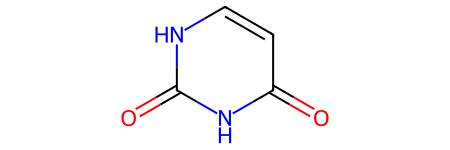

In [ ]:
mol = Chem.MolFromSmiles(molecule)
mol

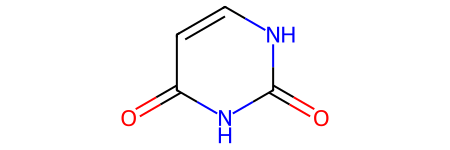

In [ ]:
mol = Chem.MolFromSmiles(harmonize_smiles_rdkit(molecule))
mol

### Postprocessing Testing

In [1]:
import dask.dataframe as dd
from rdkit.DataStructs.cDataStructs import BulkTanimotoSimilarity
from rdkit import Chem
from rdkit.Chem import MolFromSmiles
from rdkit.Chem import AllChem
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
import numpy as np
import math
from dask.distributed import Client, LocalCluster


cluster = LocalCluster()
client = Client(cluster)
client = Client(n_workers=4, threads_per_worker=1, memory_limit='auto', processes=True)
client

2023-07-10 12:06:28,586 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-1kfrnl2b', purging
2023-07-10 12:06:28,587 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-hwjya7gf', purging
2023-07-10 12:06:28,587 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-fk5_9stc', purging
2023-07-10 12:06:28,588 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-hp638vsa', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 28.61 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41149,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 28.61 GiB
Comm: tcp://127.0.0.1:46439,Total threads: 4
Dashboard: http://127.0.0.1:42235/status,Memory: 7.15 GiB
Nanny: tcp://127.0.0.1:43551,


In [2]:
df = dd.read_csv('/home/user/SourceCode/GNPS_ML_Processing_Workflow/work/06/3a7d3153673398fef6bb3957a45738/ALL_GNPS_cleaned.csv', dtype={'Smiles':str,'msDetector':str,'msDissociationMethod':str,'msManufacturer':str,'msMassAnalyzer':str,'msModel':str})
df

,scan,spectrum_id,collision_energy,retention_time,Adduct,Compound_Source,Precursor_MZ,ExactMass,Charge,Ion_Mode,Smiles,INCHI,InChIKey_smiles,InChIKey_inchi,msModel,msManufacturer,msDetector,msMassAnalyzer,msIonisation,msDissociationMethod,GNPS_library_membership,GNPS_Inst
npartitions=2,,,,,,,,,,,,,,,,,,,,,,
,int64,object,float64,float64,object,object,float64,float64,int64,object,object,object,object,object,object,object,object,object,object,object,object,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [3]:
df = df[df.Smiles.notnull()]
len(df)

/home/user/SourceCode/GNPS Library Splitting/venv/lib/python3.10/site-packages/dask/base.py:1369: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(


/home/user/SourceCode/GNPS Library Splitting/venv/lib/python3.10/site-packages/dask/dataframe/io/csv.py:193: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/home/user/SourceCode/GNPS Library Splitting/venv/lib/python3.10/site-packages/dask/dataframe/io/csv.py:193: DtypeWarning: Columns (11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)


410800

In [4]:
from rdkit import Chem
from rdkit.Chem import MolStandardize, rdMolDescriptors, MolFromSmiles
def harmonize_smiles_rdkit(smiles, tautomer_limit = 900):
    if smiles is None: return None
    try:
        smiles = str(smiles)
        # take the largest covalently bound molecule
        smiles_largest = MolStandardize.fragment.LargestFragmentChooser(smiles).prefer_organic
        mol = Chem.MolFromSmiles(smiles_largest)

        monomass = rdMolDescriptors.CalcExactMolWt(mol)
        # standardize tautomer
        if monomass < tautomer_limit:
            smiles_largest = MolStandardize.canonicalize_tautomer_smiles(smiles_largest)
            mol = Chem.MolFromSmiles(smiles_largest)

        # remove unnecessary charges
        uc = MolStandardize.charge.Uncharger()
        uncharged_mol = uc.uncharge(mol)
        
        # standardize the molecule
        lfc = MolStandardize.fragment.LargestFragmentChooser()
        standard_mol = lfc.choose(uncharged_mol)

        # remove stereochemistry
        Chem.RemoveStereochemistry(standard_mol)

        # get the standardized SMILES
        standard_smiles = Chem.MolToSmiles(standard_mol)
        return standard_smiles

    except Exception as e:
        print(f"An error occurred with input {smiles}: {e}")
        return None

In [5]:
df['Smiles'].map(harmonize_smiles_rdkit).compute(scheduler='processes')

An error occurred with input foo: Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)
An error occurred with input foo: Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(NoneType)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)


[12:06:35] SMILES Parse Error: syntax error while parsing: foo
[12:06:35] SMILES Parse Error: Failed parsing SMILES 'foo' for input: 'foo'
[12:06:35] SMILES Parse Error: syntax error while parsing: foo
[12:06:35] SMILES Parse Error: Failed parsing SMILES 'foo' for input: 'foo'
/home/user/SourceCode/GNPS Library Splitting/venv/lib/python3.10/site-packages/dask/base.py:1369: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(


/home/user/SourceCode/GNPS Library Splitting/venv/lib/python3.10/site-packages/dask/dataframe/io/csv.py:193: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
Tautomer enumeration stopped at maximum 1000
Tautomer enumeration stopped at maximum 1000
Tautomer enumeration stopped at maximum 1000
Tautomer enumeration stopped at maximum 1000
Tautomer enumeration stopped at maximum 1000
Tautomer enumeration stopped at maximum 1000
Tautomer enumeration stopped at maximum 1000
Tautomer enumeration stopped at maximum 1000
Tautomer enumeration stopped at maximum 1000
Tautomer enumeration stopped at maximum 1000
Tautomer enumeration stopped at maximum 1000
Tautomer enumeration stopped at maximum 1000
Tautomer enumeration stopped at maximum 1000
Tautomer enumeration stopped at maximum 1000
Tautomer enumeration stopped at maximum 1000
Tautomer enumeration stopped at maximum 1000
Tautomer enumeration stopped at maximum 1

In [ ]:
df